<a href="https://colab.research.google.com/github/taro-univ/PRML_Mounting/blob/main/gaussian_message_passing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#木構造:中心ノード1にほかのノードが接続
tree = nx.Graph()
tree_edges = [(1,2), (1,3), (2,4),(2,5), (3,6), (3,7)]
tree.add_edges_from(tree_edges)

In [3]:
#ノードのレイアウト(ツリー構造)
pos = nx.spring_layout(tree, seed = 42)

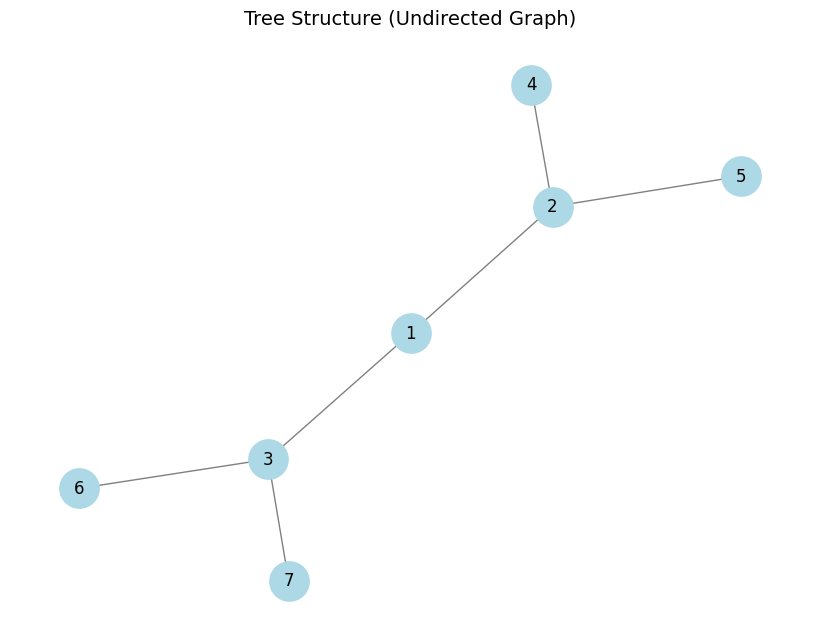

In [4]:
#描画
plt.figure(figsize = (8,6))
nx.draw(tree, pos, with_labels = True, node_color = "lightblue", node_size = 800
        , font_size = 12, edge_color = "gray")
plt.title("Tree Structure (Undirected Graph)", fontsize=14)
plt.show()

In [5]:
import numpy as np

#ノードは二値(0, 1)
#各ノードの事前分布を一様分布に設定
prior = {i : np.array([0.5, 0.5]) for i in tree.nodes}

#エッジごとのポテンシャル関数ψ(x_i, x_j)を定義
def psi(xi, xj, beta = 1.5):
    return np.exp(beta * (1 if xi == xj else -1))

#メッセージ格納
messages = {}

In [6]:
# メッセージを再帰的に送る関数（from_nodeからto_nodeへ）
def send_message(from_node, to_node, visited):
    key = (from_node, to_node)
    if key in messages:
        return messages[key] #キャッシュ利用

    neighbors = list(tree.neighbors(from_node))
    neighbors.remove(to_node) #to_nodeには再帰しない

    incoming_msgs = []
    for neighbor in neighbors:
        if (neighbor, from_node) not in visited:
            visited.add((neighbor, from_node))
            msg = send_message(neighbor, from_node, visited)
            incoming_msgs.append(msg)

    #合成メッセージ
    result = np.zeros(2)
    for x_to in [0,1]:
        total = 0
        for x_from in [0,1]:
            prod = psi(x_from, x_to) * prior[from_node][x_from]
            for msg in incoming_msgs:
                prod *= msg[x_from]

            total += prod
        result[x_to] = total

    messages[key] = result
    return result


In [7]:
# ルートノードを1とし、葉からルート方向に全メッセージを伝播
visited_set = set()
for neighbor in tree.neighbors(1):
    send_message(neighbor, 1, visited_set)

# ノード1に集まったメッセージを使ってbelief（周辺分布）を計算
belief = prior[1].copy()
for neighbor in tree.neighbors(1):
    belief *= messages[(neighbor, 1)]
belief /= belief.sum()  # 正規化

belief

array([0.5, 0.5])

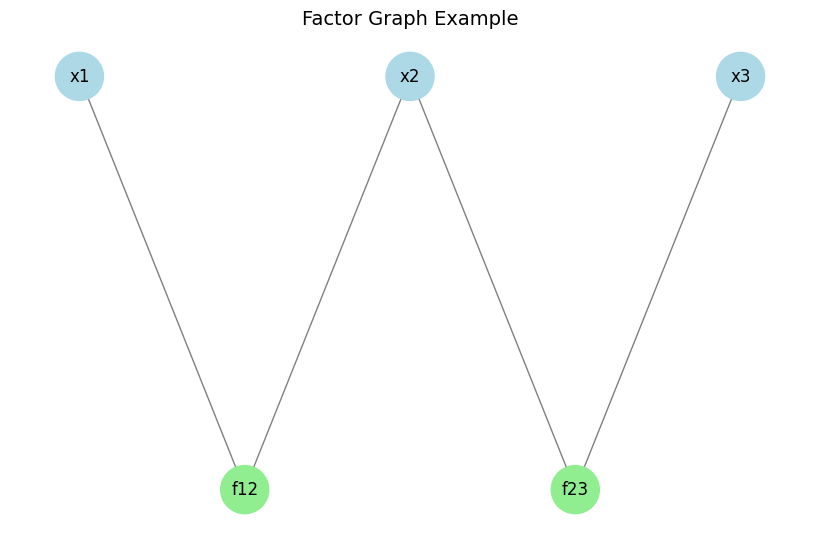

In [8]:
# 変数ノード: x1, x2, x3
# 因子ノード: f12 (x1,x2), f23 (x2,x3)
factor_graph = nx.Graph()


# ノードの追加（type属性で区別）
variables = ['x1', 'x2', 'x3']
factors = ['f12', 'f23']

factor_graph.add_nodes_from(variables, bipartite='variable')
factor_graph.add_nodes_from(factors, bipartite='factor')


# エッジの追加（因子ノードと関係する変数を接続）
factor_graph.add_edges_from([('f12', 'x1'), ('f12', 'x2'),
                             ('f23', 'x2'), ('f23', 'x3')])

# レイアウト調整（bipartite風に手動で配置）
pos = {
    'x1': (-1, 1),
    'x2': (0, 1),
    'x3': (1, 1),
    'f12': (-0.5, 0),
    'f23': (0.5, 0)
}

# 描画
plt.figure(figsize=(8, 5))
nx.draw(factor_graph, pos, with_labels=True,
        node_size=1200, node_color=['lightblue' if n in variables else 'lightgreen' for n in factor_graph.nodes],
        edge_color='gray', font_size=12)
plt.title("Factor Graph Example", fontsize=14)
plt.show()

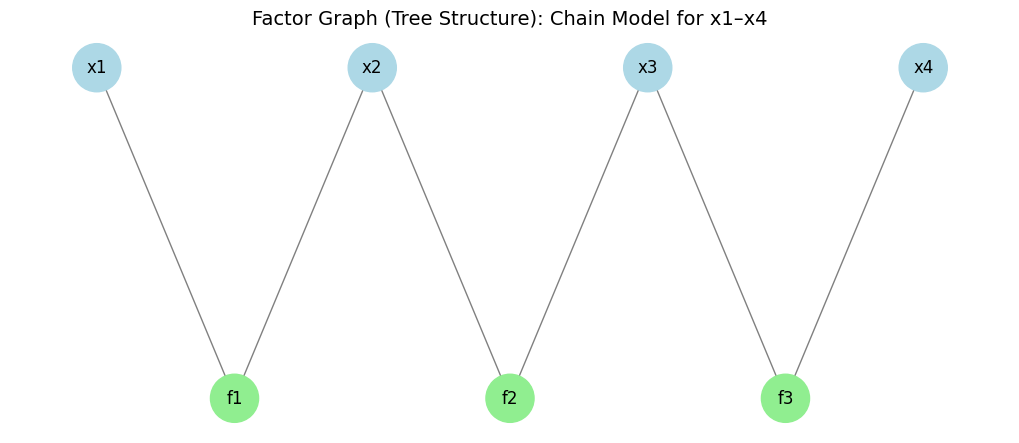

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Reconstruct factor graph (Variable nodes: x1–x4, Factor nodes: f1–f3)
variables = ['x1', 'x2', 'x3', 'x4']
factors = ['f1', 'f2', 'f3']

factor_graph = nx.Graph()
factor_graph.add_nodes_from(variables, bipartite='variable')
factor_graph.add_nodes_from(factors, bipartite='factor')

edges = [('x1', 'f1'), ('x2', 'f1'),
         ('x2', 'f2'), ('x3', 'f2'),
         ('x3', 'f3'), ('x4', 'f3')]
factor_graph.add_edges_from(edges)

# Layout for visualization
pos = {
    'x1': (-3, 1), 'x2': (-1, 1), 'x3': (1, 1), 'x4': (3, 1),
    'f1': (-2, 0), 'f2': (0, 0), 'f3': (2, 0)
}

# Drawing
plt.figure(figsize=(10, 4))
nx.draw(factor_graph, pos, with_labels=True,
        node_color=['lightblue' if n in variables else 'lightgreen' for n in factor_graph.nodes],
        node_size=1200, font_size=12, edge_color='gray')
plt.title("Factor Graph (Tree Structure): Chain Model for x1–x4", fontsize=14)
plt.axis('off')
plt.show()


In [22]:
#Binary variable domain
domain = [0, 1]

#define factor potentials
def factor_function(xi, xj, beta = 1.5):
    return np.exp(beta if xi == xj else -beta)

#create factor tables for each factor
factor_tables = {
    'f1' : {(xi, xj): factor_function(xi, xj) for xi in domain for xj in domain},
    'f2' : {(xi, xj): factor_function(xi, xj) for xi in domain for xj in domain},
    'f3' : {(xi, xj): factor_function(xi, xj) for xi in domain for xj in domain}
}

#Initialize messages: (source, target) -> array([m0, m1])
messages = {}

#set of all edges from factor_graph
for u, v in factor_graph.edges():
    messages[(u, v)] = np.ones(2)
    messages[(v, u)] = np.ones(2)

#Variable to factor message update
def update_variable_to_factor(x, f, neighbors):
    msg = np.ones(2)
    for i in domain:
        product = 1.0
        for f_n in neighbors[x]:
            if f_n != f:
                product *= messages[(f_n, x)][i]

        msg[i] = product
    messages[(x, f)] = msg

def update_factor_to_variable(f, x, neighbors):
    msg = np.ones(2)
    for x_val in domain:
        total = 0.0
        for other_val in domain:
            vars_in_f = [n for n in neighbors[f] if n != x]
            if len(vars_in_f) != 1:
                continue
            other = vars_in_f[0]
            potential = factor_tables[f][(x_val, other_val)]
            incoming = messages[(other, f)][other_val]
            total += potential * incoming
        msg[x_val] = total
    messages[(f, x)] = msg

#Define neighbor dictionary for easy access
neighbors = {n : list(factor_graph.neighbors(n)) for n in factor_graph.nodes}

evidence = {'x1': 0}

def compute_belief_with_evidence(x, messages, neighbors, evidence):
    if x in evidence:
        val = evidence[x]
        vec = np.zeros(2)
        vec[val] = 1.0  # hard evidence
        return vec
    else:
        belief = np.ones(2)
        for f in neighbors[x]:
            belief *= messages[(f, x)]
        return belief / belief.sum()


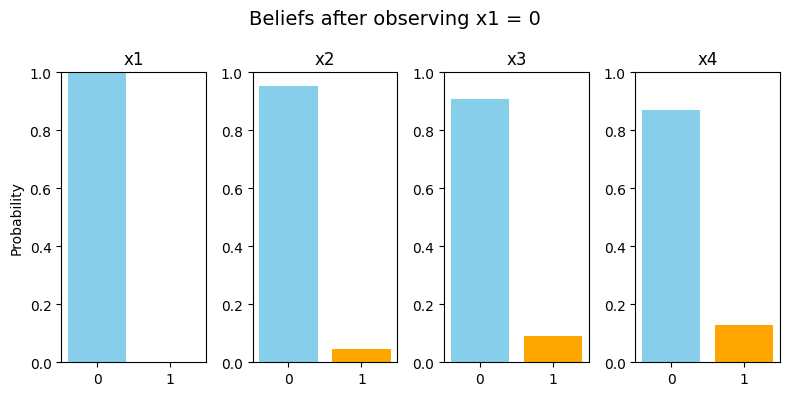

In [25]:
import matplotlib.pyplot as plt

# 観測：x1 = 0 に固定（hard evidence）
# メッセージを固定して更新
messages[('x1', 'f1')] = np.array([1.0, 0.0])

# 再びメッセージを前後に伝播（evidence反映後）
update_factor_to_variable('f1', 'x2', neighbors)
update_variable_to_factor('x2', 'f2', neighbors)
update_factor_to_variable('f2', 'x3', neighbors)
update_variable_to_factor('x3', 'f3', neighbors)
update_factor_to_variable('f3', 'x4', neighbors)

update_variable_to_factor('x4', 'f3', neighbors)
update_factor_to_variable('f3', 'x3', neighbors)
update_variable_to_factor('x3', 'f2', neighbors)
update_factor_to_variable('f2', 'x2', neighbors)
update_variable_to_factor('x2', 'f1', neighbors)
# f1→x1 は不要（観測済み）

# 新たなbeliefを計算
beliefs = {x: compute_belief_with_evidence(x, messages, neighbors, evidence) for x in variables}

# 可視化（棒グラフ）
plt.figure(figsize=(8, 4))
for i, x in enumerate(variables):
    plt.subplot(1, 4, i+1)
    plt.bar([0, 1], beliefs[x], color=['skyblue', 'orange'])
    plt.xticks([0, 1])
    plt.ylim(0, 1)
    plt.title(f'{x}')
    if i == 0:
        plt.ylabel('Probability')

plt.suptitle('Beliefs after observing x1 = 0', fontsize=14)
plt.tight_layout()
plt.show()


In [26]:
#連続変数の実装
import numpy as np

# ノード構造: x1 - f1 - x2 - f2 - x3 - f3 - x4
# 変数ノード: x1 ~ x4（連続）
# ファクター: 2変数の結合ガウス分布（線形ガウスモデル）

# 各ファクターの相関構造（x_i と x_{i+1} の結合分布）
def make_pairwise_gaussian(mu1, mu2, sigma1, sigma2, rho):
    """2変数ガウスの平均と共分散を返す"""
    mu = np.array([mu1, mu2])
    cov = np.array([
        [sigma1**2, rho * sigma1 * sigma2],
        [rho * sigma1 * sigma2, sigma2**2]
    ])
    return mu, cov

In [27]:
from scipy.stats import multivariate_normal

# 初期条件：x1を観測（x1 = 0）
mu_x1 = 0.0
sigma_x1 = 1e-6  # 実質的に delta関数と同じ（観測）

# f1: x1 - x2
mu_f1, cov_f1 = make_pairwise_gaussian(0, 0, 1, 1, rho=0.9)

# message from x1 to f1 is observation
def message_from_observed(x_val):
    return lambda x: np.exp(-0.5 * ((x - x_val) ** 2) / sigma_x1**2)

# メッセージを伝播（x1固定 → x2 → x3 → x4）
def marginal_after_messages():
    # ステップ1: message from x1 to f1 is fixed (delta function at x1 = 0)
    x1_val = 0.0

    # ステップ2: message from f1 to x2
    # p(x2) = ∫ p(x1,x2) δ(x1 - x1_val) dx1 = p(x2 | x1 = x1_val)
    def conditional_gaussian(mu, cov, given_index, given_value):
        """周辺分布を条件付き分布に変換する"""
        # 2変数のガウス分布を条件付きに変換
        idx = 1 - given_index
        mu_given = mu[given_index]
        mu_target = mu[idx]
        sigma_gg = cov[given_index, given_index]
        sigma_tt = cov[idx, idx]
        sigma_tg = cov[idx, given_index]
        sigma_gg_inv = 1 / sigma_gg
        mu_cond = mu_target + sigma_tg * sigma_gg_inv * (given_value - mu_given)
        sigma_cond = sigma_tt - sigma_tg**2 * sigma_gg_inv
        return mu_cond, sigma_cond

    mu_x2, sigma2 = conditional_gaussian(mu_f1, cov_f1, given_index=0, given_value=x1_val)

    # f2: x2 - x3（同様にガウス相関）
    mu_f2, cov_f2 = make_pairwise_gaussian(0, 0, 1, 1, rho=0.9)
    mu_x3, sigma3 = conditional_gaussian(mu_f2, cov_f2, given_index=0, given_value=mu_x2)

    # f3: x3 - x4
    mu_f3, cov_f3 = make_pairwise_gaussian(0, 0, 1, 1, rho=0.9)
    mu_x4, sigma4 = conditional_gaussian(mu_f3, cov_f3, given_index=0, given_value=mu_x3)

    return mu_x4, sigma4


In [28]:
mu, sigma = marginal_after_messages()
print(f"x4 の周辺分布: 平均 = {mu:.4f}, 標準偏差 = {np.sqrt(sigma):.4f}")


x4 の周辺分布: 平均 = 0.0000, 標準偏差 = 0.4359


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas

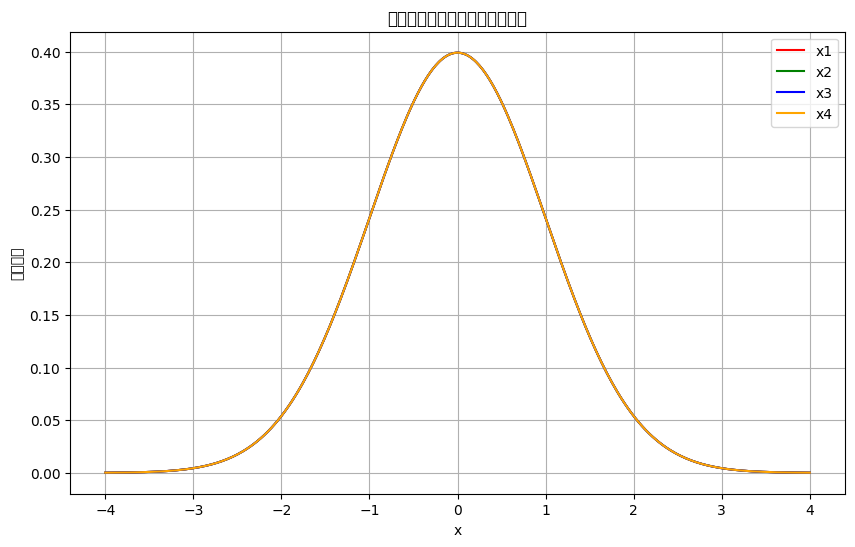

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- パラメータ設定 ---
rho = 0.9
dim = 4

# 共分散行列を構築（Toeplitz型：|i-j|の距離で減衰）
Sigma = np.array([[rho**abs(i-j) for j in range(dim)] for i in range(dim)])
mu = np.zeros(dim)

# --- 各変数の周辺分布を計算 ---
# 多変量正規分布の周辺分布は、該当次元のμ_i, Σ_iiで与えられる
x_vals = np.linspace(-4, 4, 400)
colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=(10, 6))
for i in range(dim):
    var_i = Sigma[i, i]
    pdf_vals = norm.pdf(x_vals, loc=mu[i], scale=np.sqrt(var_i))
    plt.plot(x_vals, pdf_vals, label=f"x{i+1}", color=colors[i])

plt.title("各変数の周辺分布（観測なし）")
plt.xlabel("x")
plt.ylabel("確率密度")
plt.legend()
plt.grid(True)
plt.show()


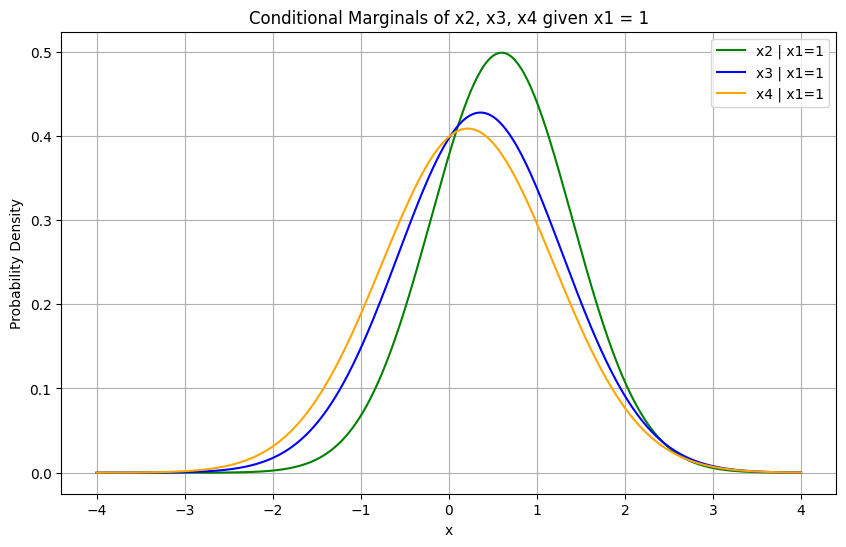

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
rho = 0.6
dim = 4
mu = np.zeros(dim)
Sigma = np.array([[rho**abs(i-j) for j in range(dim)] for i in range(dim)])

# Conditioning on x1 = 1
mu1 = mu[0:1]  # shape (1,)
mu_rest = mu[1:]  # x2, x3, x4
Sigma_11 = Sigma[0:1, 0:1]
Sigma_12 = Sigma[0:1, 1:]
Sigma_21 = Sigma[1:, 0:1]
Sigma_22 = Sigma[1:, 1:]

# Conditional mean and covariance
Sigma_11_inv = np.linalg.inv(Sigma_11)
mu_cond = mu_rest + (Sigma_21 @ Sigma_11_inv @ (1 - mu1))
Sigma_cond = Sigma_22 - Sigma_21 @ Sigma_11_inv @ Sigma_12

# Plotting conditional marginals
x_vals = np.linspace(-4, 4, 400)
colors = ['g', 'b', 'orange']
labels = ['x2 | x1=1', 'x3 | x1=1', 'x4 | x1=1']

plt.figure(figsize=(10, 6))
for i in range(3):
    pdf_vals = norm.pdf(x_vals, loc=mu_cond[i], scale=np.sqrt(Sigma_cond[i, i]))
    plt.plot(x_vals, pdf_vals, label=labels[i], color=colors[i])

plt.title("Conditional Marginals of x2, x3, x4 given x1 = 1")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()



In [35]:
#max-sum Inference
